In [1]:
import os
import cv2
import scipy
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile

file_name = 'train.zip'

with zipfile.ZipFile('/content/drive/My Drive/' + file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/tmp')

In [4]:
ls


drive/  sample_data/  tmp/


In [5]:
cwd = os.getcwd()
print(cwd)
train_data_dir = "tmp/train"
train_imgs = os.listdir(os.path.join(cwd,train_data_dir))


/content


In [6]:

def extractFeaturesAndLabels(dir, impg_dataset,num_px):
  X = np.zeros((len(impg_dataset), num_px*num_px*3))
  y = np.zeros((len(impg_dataset)))
  for i in range(0,len(impg_dataset)) :

    image = cv2.imread(os.path.join(dir, impg_dataset[i]))
    if image is not None:
        image = cv2.resize(image, (num_px, num_px))

        image = image.reshape((1, num_px*num_px*3)).T

        image = image/255.0

        image = image.reshape((num_px*num_px*3,1))
        for j in range(0,num_px*num_px*3):
            X[i][j] = image[j][0]

        if 'negative' in impg_dataset[i]:
            y[i] = 0
        else :
            y[i] = 1
    else:
        continue

  y = y.astype(int)

  return(X, y)

def extractFeaturesAndLabelsForSubmission(dir, impg_dataset,num_px):
  X = np.zeros((len(impg_dataset), num_px*num_px*3))
  y = np.empty(len(impg_dataset), dtype='<U100')  # Set the dtype to string with an appropriate length
  for i in range(0,len(impg_dataset)) :

    image = cv2.imread(os.path.join(dir, impg_dataset[i]))
    if image is not None:
        image = cv2.resize(image, (num_px, num_px))

        image = image.reshape((1, num_px*num_px*3)).T

        image = image/255.0

        image = image.reshape((num_px*num_px*3,1))
        for j in range(0,num_px*num_px*3):
            X[i][j] = image[j][0]

        y[i] = impg_dataset[i].split(".")[0]
    else:
        continue


  return(X, y)

def get_accuracy(model, X, y):
  y_pred = model.predict(X)

  if sys.version_info < (3, 0):
      accuracy = ((np.sum(y == y_pred, axis=0)).astype('float') /
            X.shape[0])
  else:
      accuracy = np.sum(y == y_pred, axis=0) / X.shape[0]

  #print('Accuracy: %.2f%%' % (accuracy * 100))

  return(accuracy * 100)

def printer():
    print("hi u can connect to me")
import numpy as np
from scipy.special import expit
import sys

class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
    n_hidden : int (default: 30)
        Number of hidden units.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the
        gradient of the previous epoch t-1 to improve
        learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    def predict_proba(self, X):
        """Predict class probabilities

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        proba : array, shape = [n_output_units, n_samples]
            Predicted class probabilities.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                'Use X[:,None] for 1-feature classification,'
                                '\nor X[[i]] for 1-sample classification')

        _, _, _, _, a3 = self._feedforward(X, self.w1, self.w2)
        return a3
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self



In [7]:
num_px = 70
X_train, y_train = extractFeaturesAndLabels(train_data_dir, train_imgs,num_px)



In [8]:
print(len(X_train))

32107


In [9]:
test_size = 0.2
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)


In [10]:
# X_test_submit, y_test_submit = extractFeaturesAndLabelsForSubmission(test_data_dir, test_imgs, num_px)

In [11]:
print('Training Data set - Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('Test Data set - Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Training Data set - Rows: 25685, columns: 14700
Test Data set - Rows: 6422, columns: 14700


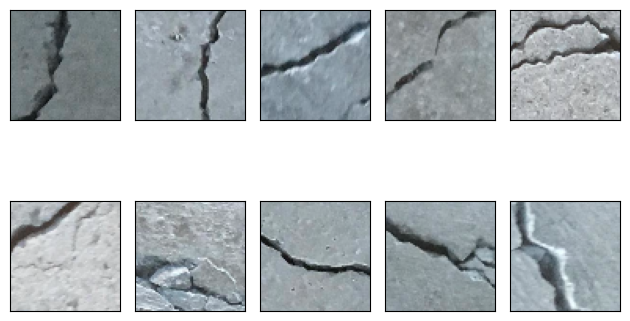

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == 1][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

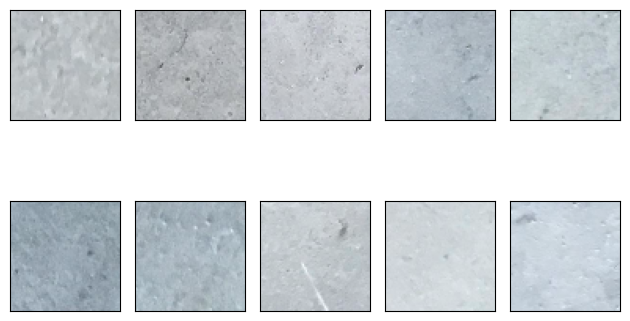

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == 0][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [14]:
X_train.shape

(25685, 14700)

In [15]:
nn = NeuralNetMLP(n_output=2,
                  n_features=X_train.shape[1],
                  n_hidden=50,
                  l2=0.1,
                  l1=0.1,
                  epochs=50,
                  eta=0.01,
                  alpha=0.01,
                  decrease_const=0.00001,
                  minibatches=100,
                  shuffle=True,
                  random_state=1)

In [16]:
nn.fit(X_train, y_train, print_progress=True)


Epoch: 1/50<ipython-input-6-588de52e8b89>:256: RuntimeWarning: divide by zero encountered in log
  term2 = (1.0 - y_enc) * np.log(1.0 - output)
<ipython-input-6-588de52e8b89>:256: RuntimeWarning: invalid value encountered in multiply
  term2 = (1.0 - y_enc) * np.log(1.0 - output)
Epoch: 50/50

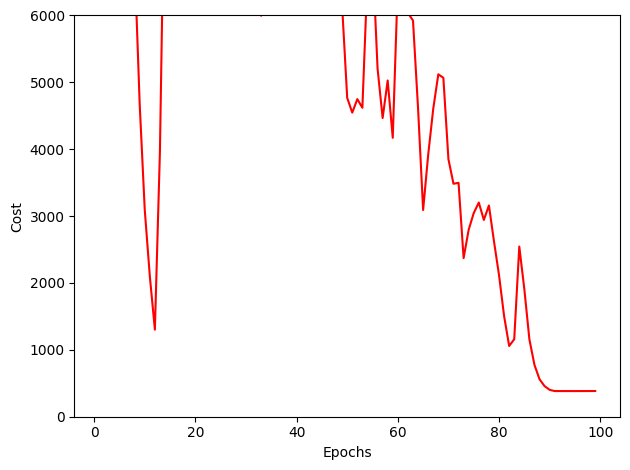

In [17]:
batches = np.array_split(range(len(nn.cost_)), 100)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 6000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

In [18]:
def get_accuracy(model, X, y):
  y_pred = model.predict(X)

  if sys.version_info < (3, 0):
      accuracy = ((np.sum(y == y_pred, axis=0)).astype('float') /
            X.shape[0])
  else:
      accuracy = np.sum(y == y_pred, axis=0) / X.shape[0]

  #print('Accuracy: %.2f%%' % (accuracy * 100))

  return(accuracy * 100)

training_accuracy=get_accuracy(nn, X_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_accuracy(nn, X_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)

Training accuracy: 49.97%
Test accuracy: 49.88%


In [19]:
# standard
# training accuracy = 50.03%, test accuracy = 50.12%

# n_hidden = 50 --> 100
# training accuracy = 50.03%, test accuracy = 50.12%

# l1 = 0.1 --> 0.01
# training accuracy = 50.02%, test accuracy = 50.09%

#eta = 0.001 --> 0.01
# training accuracy = 49.97%, test accuracy = 49.88%

# change pix 70 --> 24
# training accuracy = 50.03%, test accuracy = 50.12%

# pix at 24, n_hidden = 50-->75
# training accuracy = 49.97%, test accuracy = 49.88%


In [20]:
# file_name = "test.zip"
# with zipfile.ZipFile('/content/drive/My Drive/' + file_name, 'r') as zip_ref:
#     zip_ref.extractall('/content/tmp')
# cwd = os.getcwd()
# print(cwd)
# test_data_dir = "tmp/test"
# test_imgs = os.listdir(os.path.join(cwd,test_data_dir))
# X_submit, y_submit = extractFeaturesAndLabelsForSubmission(test_data_dir, test_imgs,num_px)


In [21]:
# def predictAndWriteToCSV(model, X_test, y_test, output_csv_path):
#     # Make predictions on the test data
#     predictions = model.predict(X_test)
#     print(X_test.shape)
#     print(predictions.shape)
#     print(predictions)
#     # Create a DataFrame with file names and corresponding predictions
#     result_df = pd.DataFrame({
#         'File_Name': y_test,
#         'Predicted_Label': predictions  # Assuming predictions is a 1D array
#     })

#     # Write the DataFrame to a CSV file
#     result_df.to_csv(output_csv_path, index=False)

# predictAndWriteToCSV(nn, X_submit, y_submit, 'output_predictions.csv')
